# Проект «Продажи компьютерных игр»
В этом проекте мы проведем анализ продаж компьютерных игр для интернет-магазина «Стримчик».

**Наша задача** - выявить определяющие успешность игры закономерности, что поможет нам спланировать будущие рекламные кампании.

Мы возьмем исторические **данные** о продажах игр из открытых источников, где содержатся информация об оценках пользователей и экспертов, жанрах и платформах.

**Цели**, которые мы перед собой ставим:
- определить наиболее прибыльные платформы;
- выявить влияние оценок пользователей и критиков на продажи;
- определить наиболее прибыльные жанры;
- обрисовать портрет пользователя для каждого региона:
 - установить ТОП-5 платформ;
 - установить ТОП-5 жанров;
 - выявить влияние рейтинга ESRB на продажи в каждом регионе;
- проверить гипотезы.

Наш **план работы**:
- обработать данные от пропусков и дубликатов, подготовить к анализу;
- провести исследовательский анализ данных и построить графики по годам, платформам, жанрам и др.;
- составить ТОП-5 по платформам и жанрам для каждого региона;
- проверить влияние возрастного рейтинга на продажи;
- проверить две гипотезы:
 - средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
 - средние пользовательские рейтинги жанров Action и Sports одинаковые.


In [2]:
# загрузим библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
from scipy import stats as st
import numpy as np
import seaborn as sns

## Знакомство с данными

Загрузим данные, выведем общую информацию и первые несколько строк.

In [3]:
games = pd.read_csv('games.csv')
games.info()
games.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### Комментарий
В датафрейме 16 715 строк, по количеству значений в каждом столбце мы сразу видим наличие пропусков в последних трёх столбцах: "Critic_Score", "User_Score" и "Rating".
У нас есть информация по названиям игр, их жанрам, году выпуска, платформам, где можно в них играть, а также данные о продажам в разных регионах, оценки критиков и пользователей и возрастной рейтинг.

## Предобработка данных

### Названия столбцов

Названия столбцов не соответствуют "змеиному" регистру, их нужно скорректировать.

In [4]:
games.columns = games.columns.str.lower()
games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Изменение типов данных

При знакомстве с данными мы обнаружили, что в некоторых столбцах требуется смена типа данных. 

В столбце "user_score" есть значение "tbd", что расшифровывается как "to be determined" - "предстоит определить". По сути это означает, что у нас нет данных об оценке, поэтому заменим на NaN и изменим тип данных с object на float64.

В столбце "year_of_release" нужно изменить тип данных с float64 на int64, потому что указан только год, а не полная дата. Для этого, нужно избавиться от пропусков NaN в этом столбце. Их 269, поэтому особого влияния на дальнейший анализ это не окажет.

In [5]:
display(games.query('user_score == "tbd"').head(10))
games['user_score'] = pd.to_numeric(games['user_score'], errors='coerce')

print('Пропусков в столбце "year_of_release":', games['year_of_release'].isna().sum())
games = games.dropna(subset=['year_of_release'])
games['year_of_release'] = games['year_of_release'].astype('int')

games.info()
games.head()



,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010.0,Sports,3.45,2.59,0.00,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005.0,Misc,2.08,1.35,0.00,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011.0,Sports,1.51,1.03,0.00,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010.0,Misc,1.65,0.57,0.00,0.20,71.0,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.00,0.07,73.0,tbd,E
718,Just Dance Kids,Wii,2010.0,Misc,1.52,0.54,0.00,0.18,NaN,tbd,E
726,Dance Dance Revolution X2,PS2,2009.0,Simulation,1.09,0.85,0.00,0.28,NaN,tbd,E10+
821,The Incredibles,GBA,2004.0,Action,1.15,0.77,0.04,0.10,55.0,tbd,E
881,Who wants to be a millionaire,PC,1999.0,Misc,1.94,0.00,0.00,0.00,NaN,tbd,E
1047,Tetris Worlds,GBA,2001.0,Puzzle,1.25,0.39,0.00,0.06,65.0,tbd,E


Пропусков в столбце "year_of_release": 269
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16446 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16446 non-null  object 
 2   year_of_release  16446 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16446 non-null  float64
 5   eu_sales         16446 non-null  float64
 6   jp_sales         16446 non-null  float64
 7   other_sales      16446 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           9768 non-null   object 
dtypes: float64(6), int32(1), object(4)
memory usage: 1.4+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


В остальных столбцах тип данных указан верно, можем переходить к обработке оставшихся пропусков.

### Обработка пропусков

Проверим все столбцы на наличие пропущенных значений и устраним их там, где возможно.

name                  2
platform              0
year_of_release       0
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8463
user_score         8983
rating             6678
dtype: int64


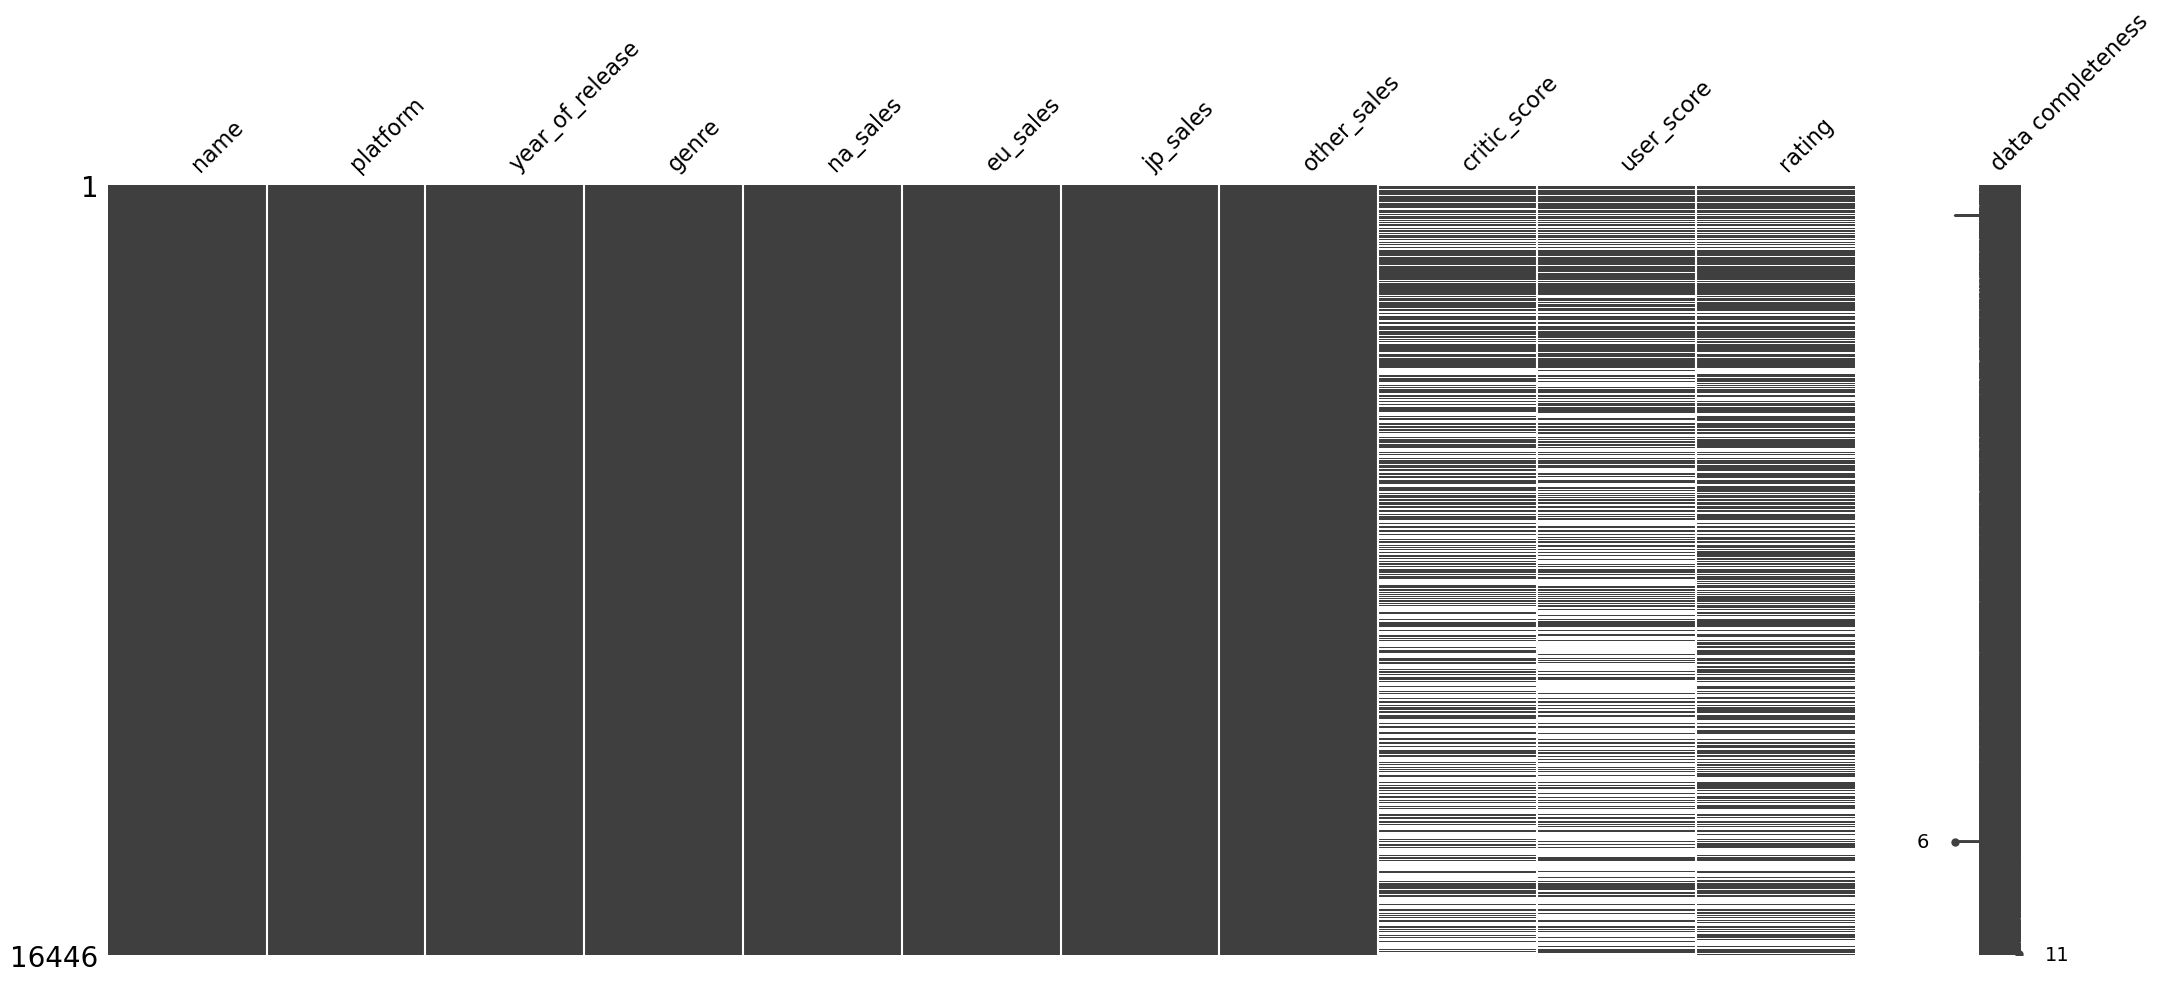

In [6]:
print(games.isna().sum())
msno.matrix(games, labels=True)

games = games.dropna(subset=['name', 'genre'])

games['rating'] = games['rating'].fillna('no rating')

В столбцах "name" и "genre" всего по 2 пропуска, можем эти строки удалить.

В столбцах "critic_score", "user_score" и "rating" слишком много пропусков, более 6 тыс. в каждом. Если мы заменим их на медиану, то это может сильно исказить данные. Поэтому лучшим решением будет оставить пропуски.

### Обработка дубликатов

Теперь проверим есть ли в датафрейме дубликаты и избавимся от них, если потребуется.

In [7]:
print('Количество дубликатов:', games.duplicated().sum())
print(games['platform'].unique())
print(games['genre'].unique())
print(games['rating'].unique())
print('Количество дубликатов по комбинации: название игры, платформа, год выпуска:', games[['name', 'platform', 'year_of_release']].duplicated().sum())
display(games[['name', 'platform', 'year_of_release']].value_counts().head())
games[['name', 'platform', 'year_of_release']] = games[['name', 'platform', 'year_of_release']].drop_duplicates()
print('После удаления дубликатов:', games[['name', 'platform', 'year_of_release']].duplicated().sum())

Количество дубликатов: 0
['Wii' 'NES' 'GB' 'DS' 'X360' 'PS3' 'PS2' 'SNES' 'GBA' 'PS4' '3DS' 'N64'
 'PS' 'XB' 'PC' '2600' 'PSP' 'XOne' 'WiiU' 'GC' 'GEN' 'DC' 'PSV' 'SAT'
 'SCD' 'WS' 'NG' 'TG16' '3DO' 'GG' 'PCFX']
['Sports' 'Platform' 'Racing' 'Role-Playing' 'Puzzle' 'Misc' 'Shooter'
 'Simulation' 'Action' 'Fighting' 'Adventure' 'Strategy']
['E' 'no rating' 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP']
Количество дубликатов по комбинации: название игры, платформа, год выпуска: 1


name                        platform  year_of_release
Madden NFL 13               PS3       2012               2
 Beyblade Burst             3DS       2016               1
Ratatouille                 PC        2007               1
Rapala Tournament Fishing!  X360      2006               1
Rapala Trophies             PSP       2006               1
dtype: int64

После удаления дубликатов: 0


Явных дубликатов мы не выявили.

Проверили также столбцы "platform", "genre" и "rating" на наличие неявных дубликатов, которых тоже не оказалось.

Дополнительно проверили по комбинации: название игры, платформа, год выпуска, - нашли один дубликат и удалили.

### Добавление расчетов

Добавим в наш датафрейм расчет суммарных продаж во всех регионах.

In [8]:
games['sum_sales'] = games['na_sales']+games['eu_sales']+games['jp_sales']+games['other_sales']
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,no rating,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,no rating,31.38


### Промежуточный вывод
- мы переименовали столбцы в "змеином" регистре;
- изменили типы данных в столбцах "user_score" и "year_of_release" на float64 и int64 соответственно;
- удалили пропуски в столбцах "year_of_release", "name" и "genre", а в столбцах "critic_score" и "user_score" оставили, поскольку пропусков слишком много, и замена медианой может сильно исказить данные, в столбце "rating" заменили все пропуски на категорию 'no rating' для дальнейшего анализа;
- проверили данные на наличие дубликатов, нашли один по комбинации - название игры, платформа, год выпуска - и удалили;
- добавили столбец с расчетом суммарных продаж во всех регионах.

## Исследовательский анализ данных

### Сколько игр выпускалось в разные годы?

Посмотрим, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

count    16443.000000
mean      2006.485921
std          5.875546
min       1980.000000
25%       2003.000000
50%       2007.000000
75%       2010.000000
max       2016.000000
Name: year_of_release, dtype: float64


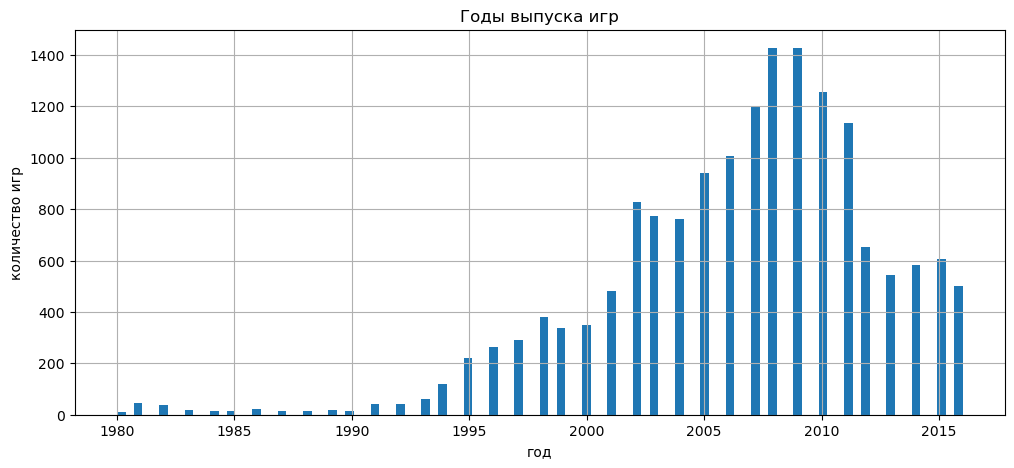

In [9]:
games['year_of_release'].hist(bins=100, figsize=(12,5))
print(games['year_of_release'].describe())
plt.title('Годы выпуска игр')
plt.xlabel('год')
plt.ylabel('количество игр')
plt.show()

Мы видим, что с 1980 по 2000 годы игр было выпущено не так немного, и этот период мы можем отбросить.

### Как менялись продажи по платформам?

Посмотрим, как менялись продажи по платформам. Сначала выберем платформы с наибольшими суммарными продажами.

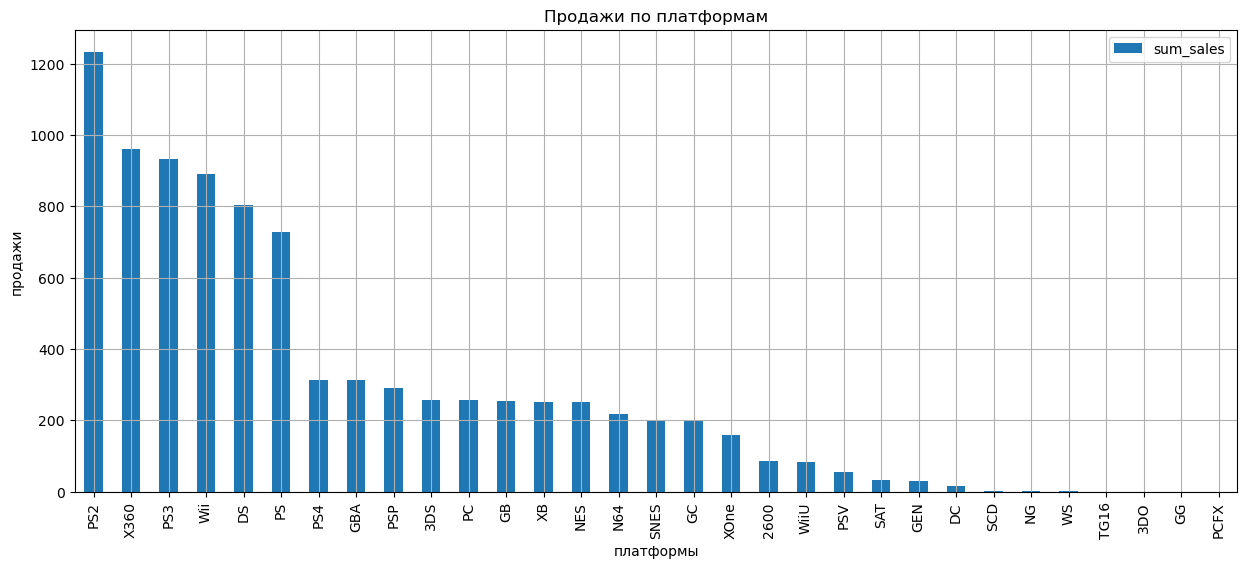

,sum_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.33
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


In [10]:
games.pivot_table(index='platform', values='sum_sales', aggfunc='sum').sort_values('sum_sales', ascending=False).plot(grid=True, figsize=(15,6), kind='bar')
plt.title('Продажи по платформам')
plt.xlabel('платформы')
plt.ylabel('продажи')
plt.show()

games.pivot_table(index='platform', values='sum_sales', aggfunc='sum').sort_values('sum_sales', ascending=False).head(10)

Возьмем первые 6 платформ с наибольшими продажами и построим распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

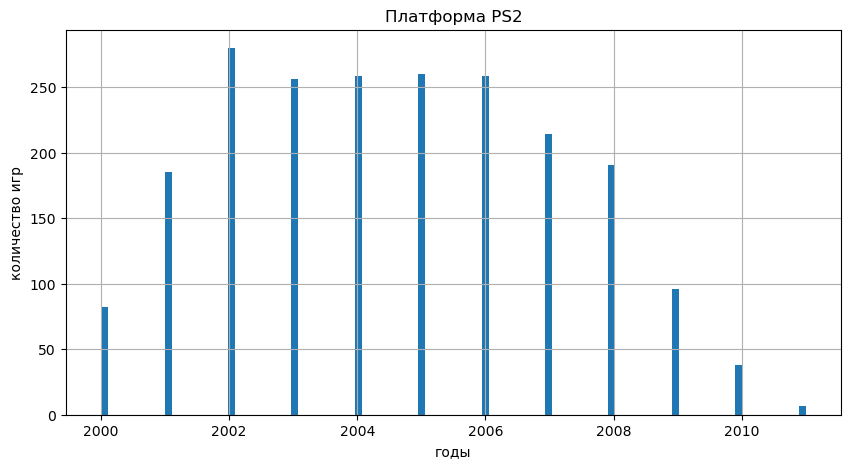

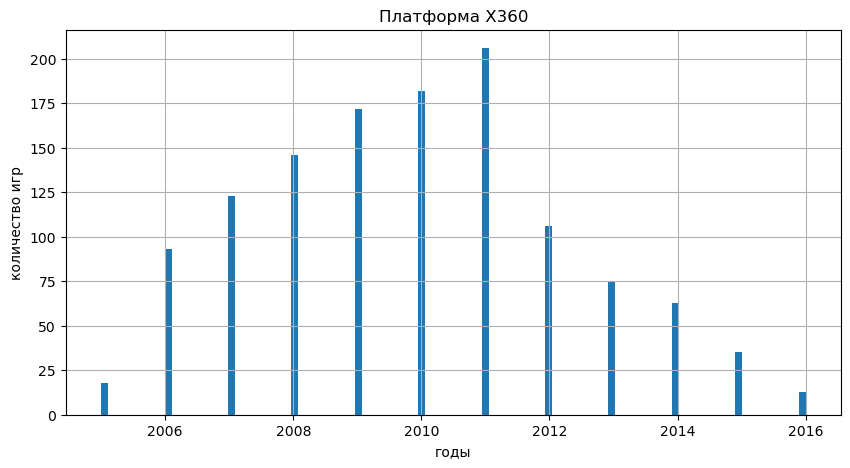

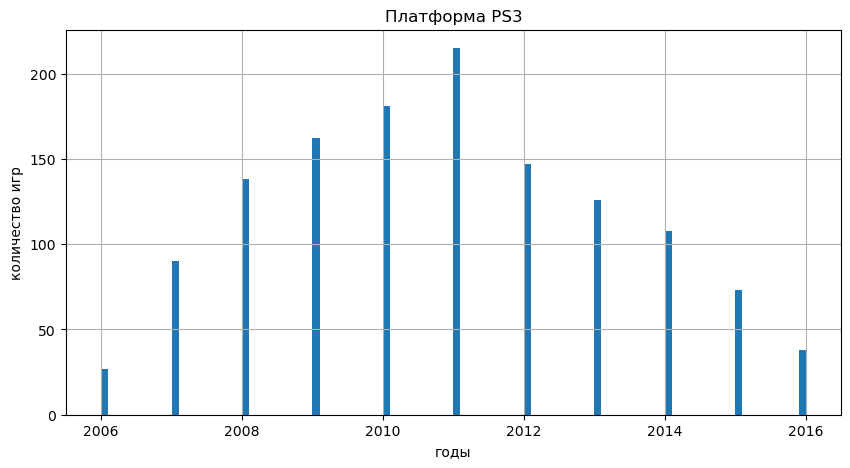

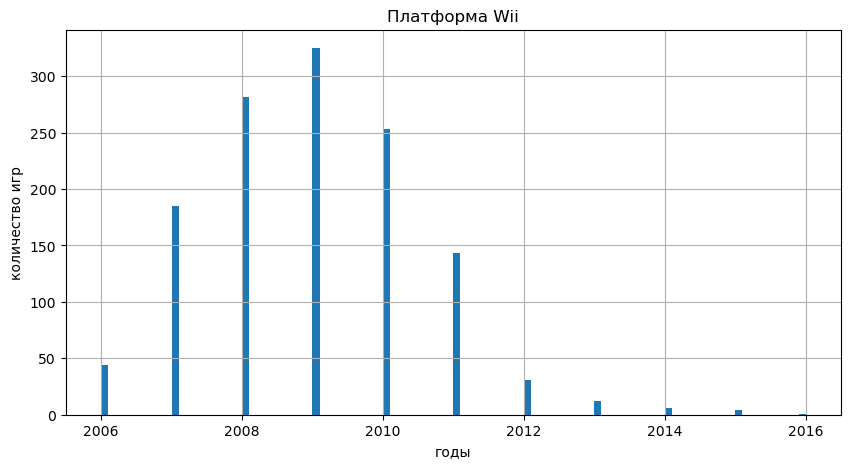

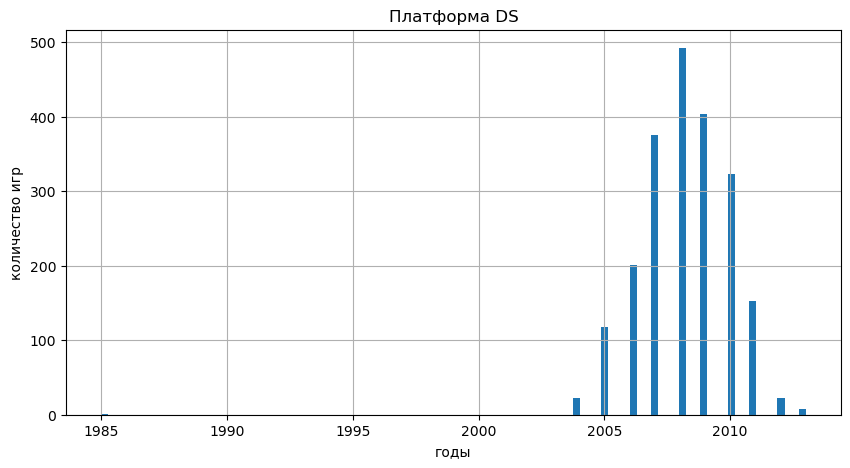

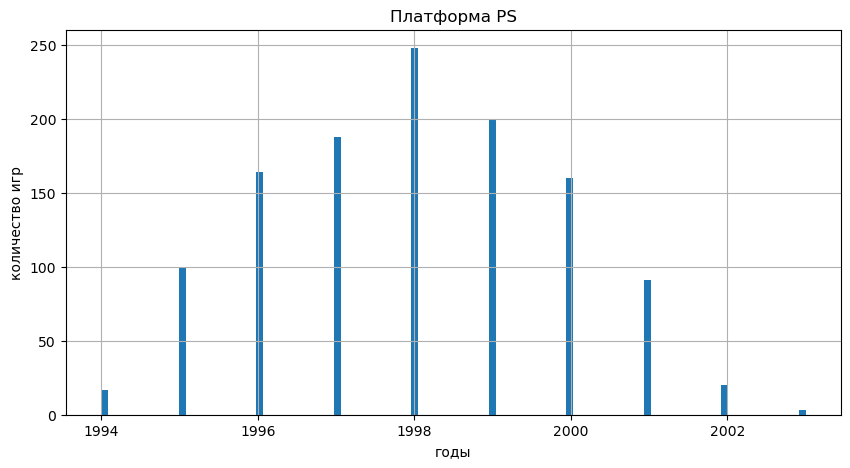

In [11]:
games.query('platform == "PS2"')['year_of_release'].hist(bins=100, figsize=(10,5))
plt.title('Платформа PS2')
plt.xlabel('годы')
plt.ylabel('количество игр')
plt.show()
games.query('platform == "X360"')['year_of_release'].hist(bins=100, figsize=(10,5))
plt.title('Платформа X360')
plt.xlabel('годы')
plt.ylabel('количество игр')
plt.show()
games.query('platform == "PS3"')['year_of_release'].hist(bins=100, figsize=(10,5))
plt.title('Платформа PS3')
plt.xlabel('годы')
plt.ylabel('количество игр')
plt.show()
games.query('platform == "Wii"')['year_of_release'].hist(bins=100, figsize=(10,5))
plt.title('Платформа Wii')
plt.xlabel('годы')
plt.ylabel('количество игр')
plt.show()
games.query('platform == "DS"')['year_of_release'].hist(bins=100, figsize=(10,5))
plt.title('Платформа DS')
plt.xlabel('годы')
plt.ylabel('количество игр')
plt.show()
games.query('platform == "PS"')['year_of_release'].hist(bins=100, figsize=(10,5))
plt.title('Платформа PS')
plt.xlabel('годы')
plt.ylabel('количество игр')
plt.show()

По этим графикам мы можем сделать вывод, что характерный срок для платформ длится от 6 до 10 лет. Таким образом, имеет смысл рассматривать данные за последние 3 года, то есть с 2014 по 2016, чтобы не брать в расчет платформы, которые потеряли свою актуальность.

In [12]:
games_final = games.query('year_of_release > 2013')
games_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689 entries, 31 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             1689 non-null   object 
 1   platform         1689 non-null   object 
 2   year_of_release  1689 non-null   float64
 3   genre            1689 non-null   object 
 4   na_sales         1689 non-null   float64
 5   eu_sales         1689 non-null   float64
 6   jp_sales         1689 non-null   float64
 7   other_sales      1689 non-null   float64
 8   critic_score     718 non-null    float64
 9   user_score       888 non-null    float64
 10  rating           1689 non-null   object 
 11  sum_sales        1689 non-null   float64
dtypes: float64(8), object(4)
memory usage: 171.5+ KB


В итоге мы сократили таблицу до 1,6 тыс. строк и будем рассматривать данные по обновленному датафрейму.

### Какие платформы лидируют по продажам?

Выберем несколько потенциально прибыльных платформ, взяв первые 5 с наибольшими продажами.

          sum_sales
platform           
PS4          288.15
XOne         140.36
3DS           86.68
PS3           68.18
X360          48.22
WiiU          42.98
PC            27.05
PSV           22.40
Wii            5.07
PSP            0.36


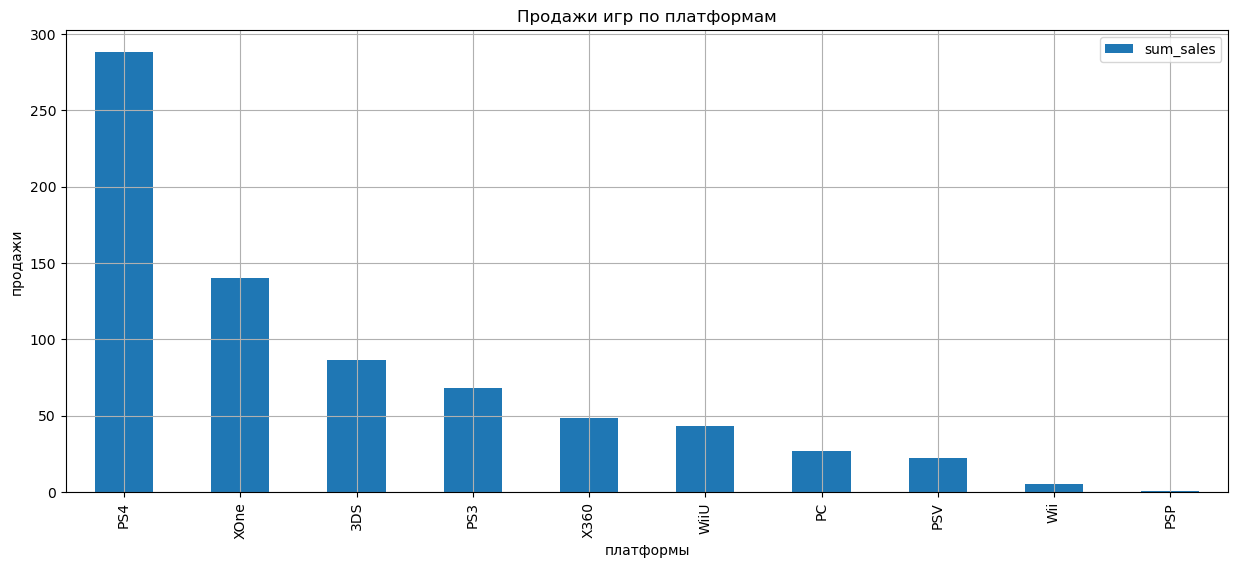

In [13]:
top_platforms = games_final.groupby('platform').agg({'sum_sales': ['sum']})
top_platforms.columns = ['sum_sales']
print(top_platforms.sort_values(by='sum_sales', ascending=False))

games_final.pivot_table(index='platform', values='sum_sales', aggfunc='sum').sort_values('sum_sales', ascending=False).plot(grid=True, figsize=(15,6), kind='bar')
plt.title('Продажи игр по платформам')
plt.xlabel('платформы')
plt.ylabel('продажи')
plt.show()

#### Диаграмма размаха по продажам

PS3
count    219.000000
mean       0.311324
std        0.633059
min        0.010000
25%        0.040000
50%        0.110000
75%        0.325000
max        5.270000
Name: sum_sales, dtype: float64
X360
count    111.000000
mean       0.434414
std        0.628967
min        0.010000
25%        0.070000
50%        0.180000
75%        0.505000
max        4.280000
Name: sum_sales, dtype: float64
PS4
count    376.000000
mean       0.766356
std        1.614969
min        0.010000
25%        0.057500
50%        0.185000
75%        0.690000
max       14.630000
Name: sum_sales, dtype: float64
3DS
count    212.000000
mean       0.408868
std        1.188368
min        0.010000
25%        0.030000
50%        0.090000
75%        0.250000
max       11.680000
Name: sum_sales, dtype: float64
XOne
count    228.000000
mean       0.615614
std        1.046513
min        0.010000
25%        0.050000
50%        0.205000
75%        0.632500
max        7.390000
Name: sum_sales, dtype: float64


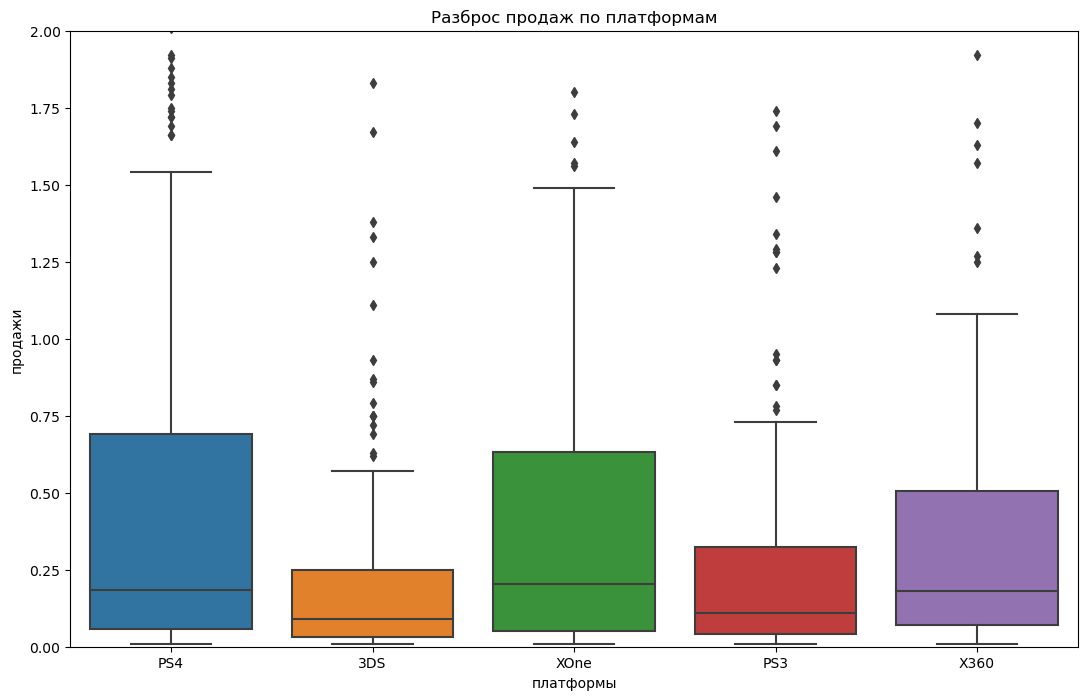

In [14]:
platforms = ['PS3', 'X360', 'PS4', '3DS', 'XOne']
plt.figure(figsize=(13, 8))
sns.boxplot(data=games_final.query('platform in @platforms'), y='sum_sales', x='platform')\
.set(
    title='Разброс продаж по платформам', xlabel='платформы', ylabel='продажи'
)
plt.ylim(0,2)

print('PS3')
print(games_final.query('platform == "PS3"')['sum_sales'].describe())
print('X360')
print(games_final.query('platform == "X360"')['sum_sales'].describe())
print('PS4')
print(games_final.query('platform == "PS4"')['sum_sales'].describe())
print('3DS')
print(games_final.query('platform == "3DS"')['sum_sales'].describe())
print('XOne')
print(games_final.query('platform == "XOne"')['sum_sales'].describe())

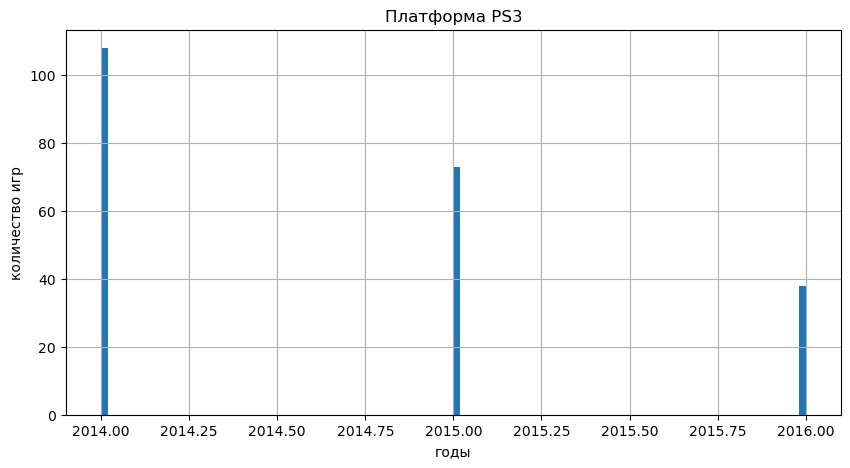

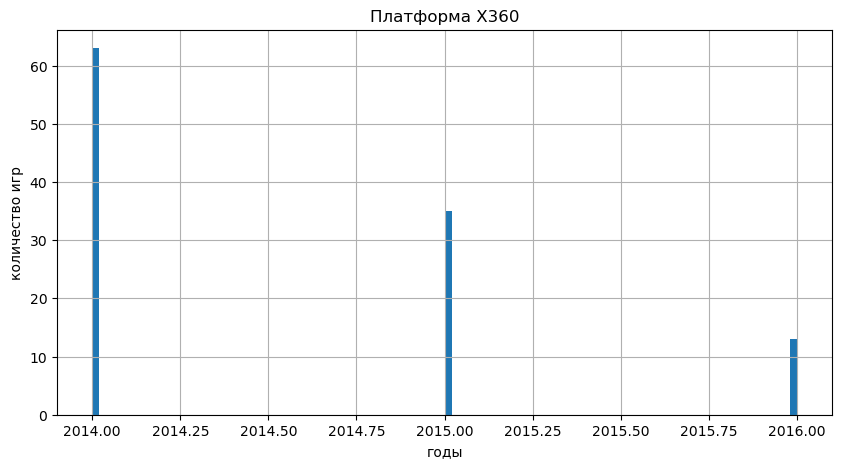

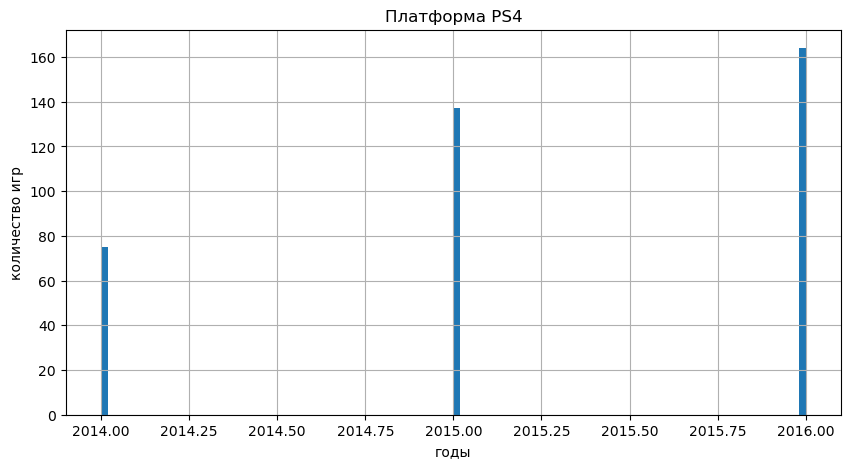

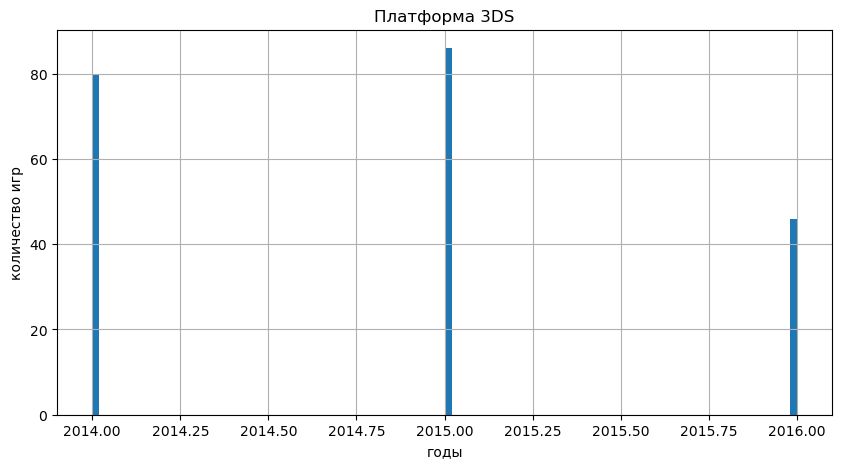

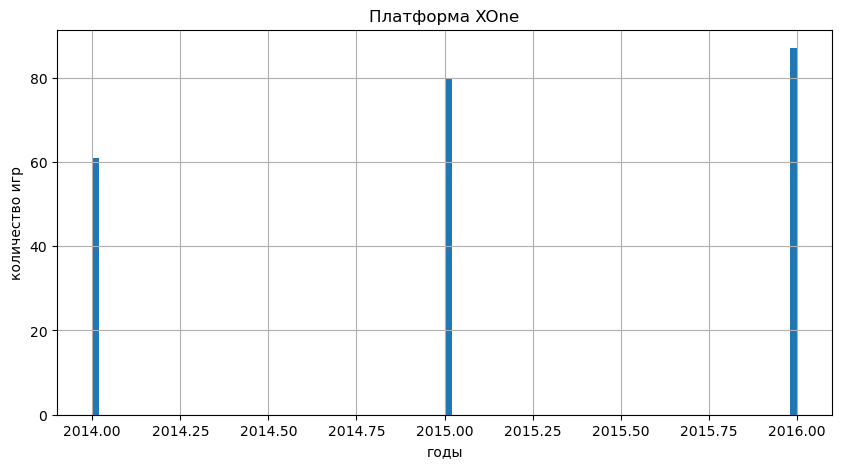

In [15]:
games_final.query('platform == "PS3"')['year_of_release'].hist(bins=100, figsize=(10,5))
plt.title('Платформа PS3')
plt.xlabel('годы')
plt.ylabel('количество игр')
plt.show()

games_final.query('platform == "X360"')['year_of_release'].hist(bins=100, figsize=(10,5))
plt.title('Платформа X360')
plt.xlabel('годы')
plt.ylabel('количество игр')
plt.show()

games_final.query('platform == "PS4"')['year_of_release'].hist(bins=100, figsize=(10,5))
plt.title('Платформа PS4')
plt.xlabel('годы')
plt.ylabel('количество игр')
plt.show()

games_final.query('platform == "3DS"')['year_of_release'].hist(bins=100, figsize=(10,5))
plt.title('Платформа 3DS')
plt.xlabel('годы')
plt.ylabel('количество игр')
plt.show()

games_final.query('platform == "XOne"')['year_of_release'].hist(bins=100, figsize=(10,5))
plt.title('Платформа XOne')
plt.xlabel('годы')
plt.ylabel('количество игр')
plt.show()


На **платформе PS3** вышло 219 игр за последние 3 года, при этом продажи варьируются в основном от 40 до 325 тыс. проданных копий, если не брать в расчет выбивающиеся значения.
По второму графику мы видим, что с каждым годом количество игр падает, так что можно сделать вывод, что PS3 уже на своем закате.

На **платформе X360** вышло 111 игр, при этом продажи варьируются в основном от 70 до 505 тыс. проданных копий, разброс уже больше, чем у PS3.
По годам здесь тоже игр становится всё меньше, как и у PS3.

На **платформе PS4** вышло 376 игры, при этом продажи варьируются в основном от 57 до 690 тыс. проданных копий, по количеству игр и продажам эта платформа отрывается от предыдущих.
По второму графику мы видим, что платформа только набирает обороты.

На **платформе 3DS** вышло 212 игр, при этом продажи варьируются в основном от 30 до 250 тыс. проданных копий, здесь разброс значительно уступает предыдущим платформам.
По второму графику количество игр постепенно идет на уменьшение.

На **платформе XOne** вышло 228 игр, при этом продажи варьируются в основном от 50 до 632 тыс. проданных копий. С учетом того, что игр у этой платформы вышло меньше, чем у PS4, разброс продаж довольно весомый. 
Второй график идет на возрастание, это значит, что платформа набирает популярность.

#### Ответ
Таким образом:
- по продажам лидирует платформы PS4, XOne и X360, но у последней количество игр идёт с каждым годом на спад;
- набирают популярность по годам платформы PS4 и XOne;
- платформа 3DS сильнее всего уступает по продажам и её популярность также постепенно идёт на спад.

Потенциально прибыльными платформами, на которые стоит обратить внимание, являются PS4 и XOne.

### Как влияют на продажи отзывы пользователей и критиков?

Посмотрим, как влияют на продажи внутри популярных платформ отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. 

Коэффициент корреляции по оценке пользователя: -0.040131589472697335


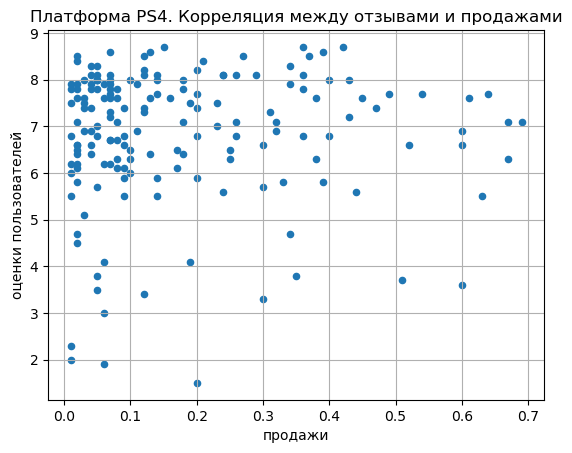

Коэффициент корреляции по оценке критика: 0.4026614106810408


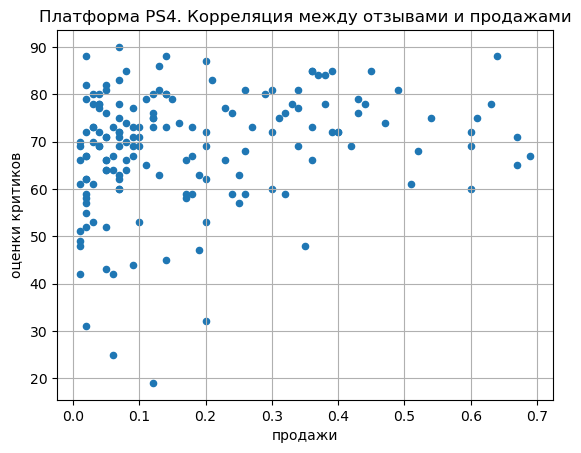

In [16]:
print('Коэффициент корреляции по оценке пользователя:', games_final.query('platform == "PS4"')['sum_sales'].corr(games_final.query('platform == "PS4"')['user_score']))

games_final.query('(platform == "PS4") and (sum_sales < 0.7)').plot(x='sum_sales', y='user_score', kind='scatter', grid=True)
plt.title('Платформа PS4. Корреляция между отзывами и продажами')
plt.xlabel('продажи')
plt.ylabel('оценки пользователей')
plt.show()

print('Коэффициент корреляции по оценке критика:', games_final.query('platform == "PS4"')['sum_sales'].corr(games_final.query('platform == "PS4"')['critic_score']))

games_final.query('(platform == "PS4") and (sum_sales < 0.7)').plot(x='sum_sales', y='critic_score', kind='scatter', grid=True)
plt.title('Платформа PS4. Корреляция между отзывами и продажами')
plt.xlabel('продажи')
plt.ylabel('оценки критиков')
plt.show()

Коэффициент корреляции по оценке пользователя: -0.07038392806475818


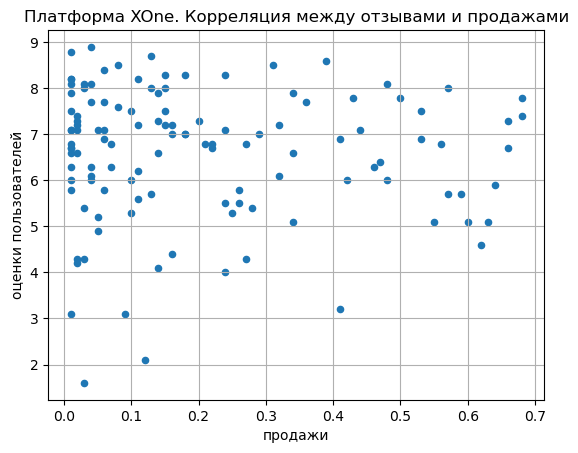

Коэффициент корреляции по оценке критика: 0.4286769437033319


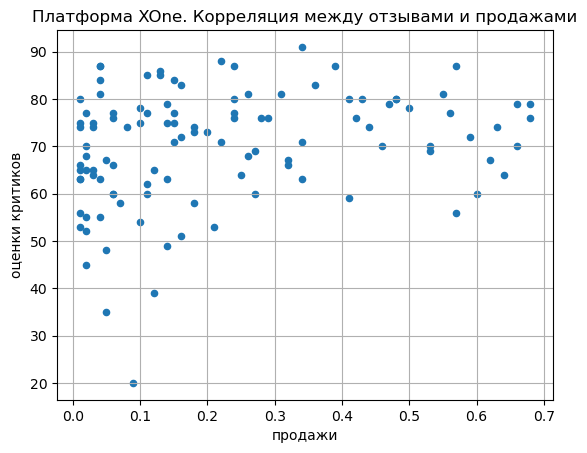

In [17]:
print('Коэффициент корреляции по оценке пользователя:', games_final.query('platform == "XOne"')['sum_sales'].corr(games_final.query('platform == "XOne"')['user_score']))

games_final.query('(platform == "XOne") and (sum_sales < 0.7)').plot(x='sum_sales', y='user_score', kind='scatter', grid=True)
plt.title('Платформа XOne. Корреляция между отзывами и продажами')
plt.xlabel('продажи')
plt.ylabel('оценки пользователей')
plt.show()

print('Коэффициент корреляции по оценке критика:', games_final.query('platform == "XOne"')['sum_sales'].corr(games_final.query('platform == "XOne"')['critic_score']))

games_final.query('(platform == "XOne") and (sum_sales < 0.7)').plot(x='sum_sales', y='critic_score', kind='scatter', grid=True)
plt.title('Платформа XOne. Корреляция между отзывами и продажами')
plt.xlabel('продажи')
plt.ylabel('оценки критиков')
plt.show()

Коэффициент корреляции по оценке пользователя: -0.16676141347662107


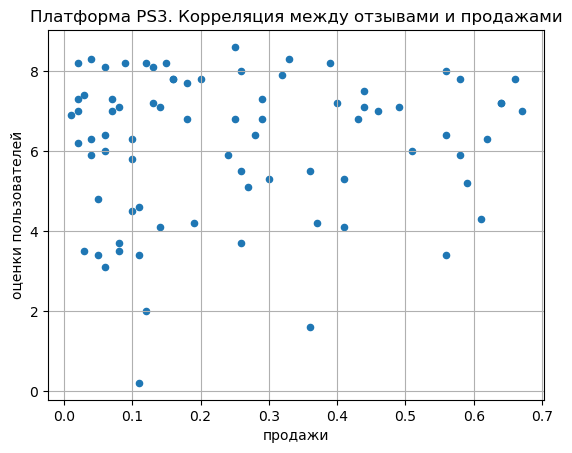

Коэффициент корреляции по оценке критика: 0.4465746049319071


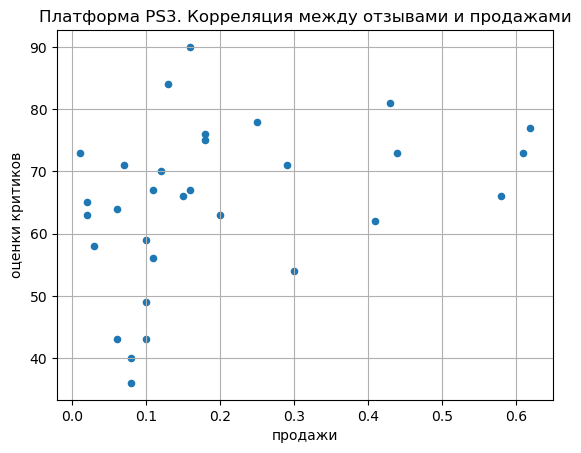

In [18]:
print('Коэффициент корреляции по оценке пользователя:', games_final.query('platform == "PS3"')['sum_sales'].corr(games_final.query('platform == "PS3"')['user_score']))

games_final.query('(platform == "PS3") and (sum_sales < 0.7)').plot(x='sum_sales', y='user_score', kind='scatter', grid=True)
plt.title('Платформа PS3. Корреляция между отзывами и продажами')
plt.xlabel('продажи')
plt.ylabel('оценки пользователей')
plt.show()

print('Коэффициент корреляции по оценке критика:', games_final.query('platform == "PS3"')['sum_sales'].corr(games_final.query('platform == "PS3"')['critic_score']))

games_final.query('(platform == "PS3") and (sum_sales < 0.7)').plot(x='sum_sales', y='critic_score', kind='scatter', grid=True)
plt.title('Платформа PS3. Корреляция между отзывами и продажами')
plt.xlabel('продажи')
plt.ylabel('оценки критиков')
plt.show()

Коэффициент корреляции по оценке пользователя: -0.13844457094566504


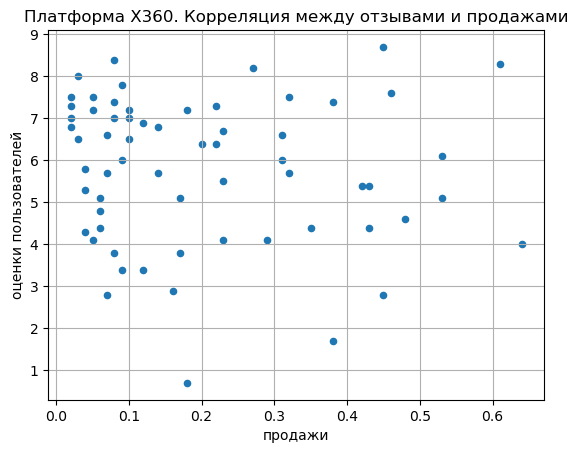

Коэффициент корреляции по оценке критика: 0.5257228356581521


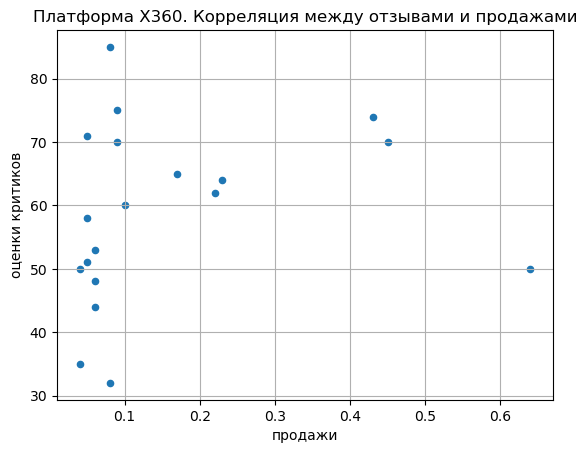

In [19]:
print('Коэффициент корреляции по оценке пользователя:', games_final.query('platform == "X360"')['sum_sales'].corr(games_final.query('platform == "X360"')['user_score']))

games_final.query('(platform == "X360") and (sum_sales < 0.7)').plot(x='sum_sales', y='user_score', kind='scatter', grid=True)
plt.title('Платформа X360. Корреляция между отзывами и продажами')
plt.xlabel('продажи')
plt.ylabel('оценки пользователей')
plt.show()

print('Коэффициент корреляции по оценке критика:', games_final.query('platform == "X360"')['sum_sales'].corr(games_final.query('platform == "X360"')['critic_score']))

games_final.query('(platform == "X360") and (sum_sales < 0.7)').plot(x='sum_sales', y='critic_score', kind='scatter', grid=True)
plt.title('Платформа X360. Корреляция между отзывами и продажами')
plt.xlabel('продажи')
plt.ylabel('оценки критиков')
plt.show()

В общем и целом строгой зависимости продаж от оценок пользователей не наблюдается, но по оценке критиков мы видим общую тенденцию - с увеличением продаж выше оценки критиков.

### Какие жанры игр самые прибыльные?

Посмотрим на общее распределение игр по жанрам.

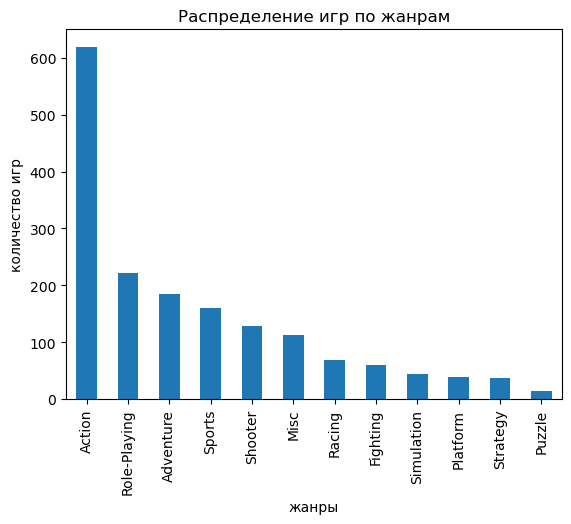

Action          619
Role-Playing    221
Adventure       185
Sports          161
Shooter         128
Misc            113
Racing           69
Fighting         60
Simulation       44
Platform         38
Strategy         37
Puzzle           14
Name: genre, dtype: int64


In [20]:
genre_count = games_final['genre'].value_counts(ascending=False)

ax = genre_count.plot.bar()

plt.title('Распределение игр по жанрам')
plt.xlabel('жанры')
plt.ylabel('количество игр')
plt.show()
print(genre_count)

Подавляющее большинство игр за последние 3 года относятся к жанру Action, следующими по популярности идут жанры Role-Playing, Adventure, Sports, Shooter и Misc.

Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами? Построим график по медианным значениям.

              sum_sales
genre                  
Shooter           0.515
Sports            0.180
Platform          0.140
Fighting          0.125
Role-Playing      0.110
Simulation        0.100
Action            0.090
Misc              0.090
Racing            0.090
Strategy          0.060
Puzzle            0.045
Adventure         0.030


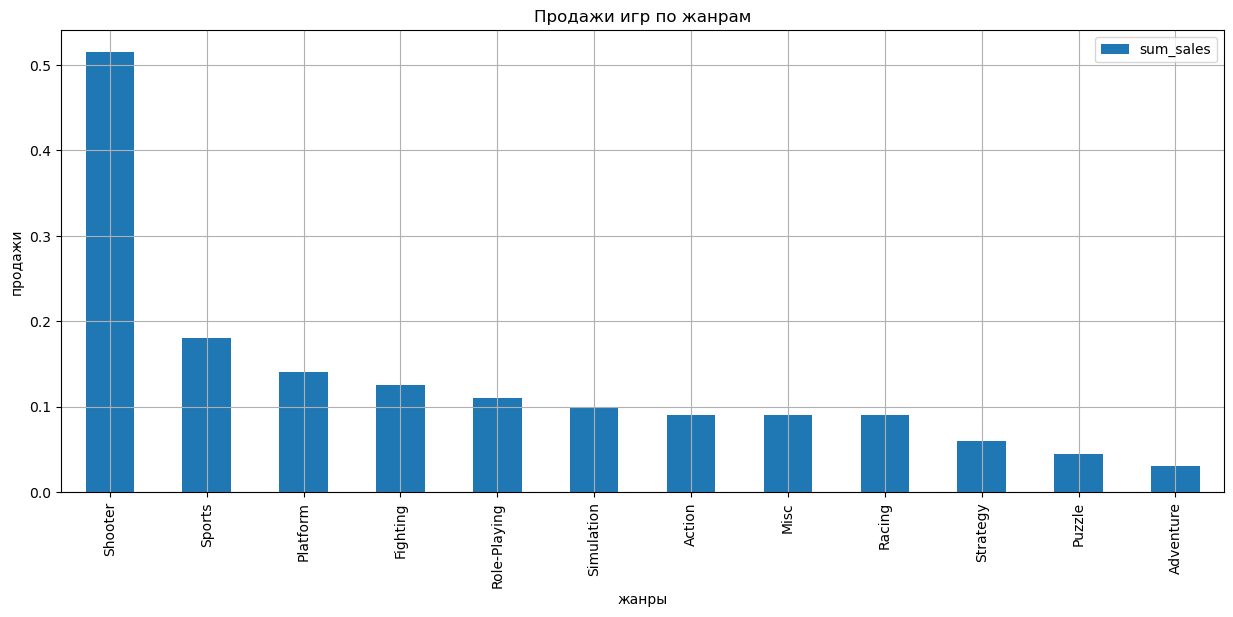

In [21]:
top_genres = games_final.groupby('genre').agg({'sum_sales': ['median']})
top_genres.columns = ['sum_sales']
print(top_genres.sort_values(by='sum_sales', ascending=False))

games_final.pivot_table(index='genre', values='sum_sales', aggfunc='median').sort_values('sum_sales', ascending=False).plot(grid=True, figsize=(15,6), kind='bar')
plt.title('Продажи игр по жанрам')
plt.xlabel('жанры')
plt.ylabel('продажи')
plt.show()

Несмотря на то, что в жанре Action вышло больше всего игр, стабильно приносит высокий доход жанр Shooter, а Action оказывается на 7 месте. Далее по продажам после Shooter идут Sports, Platform, Fighting и Role-Playing.

Также интересно отметить, что жанр Adventure, который находится на третьем месте по количеству игр, оказался по прибыльности на последнем месте. Следующими с конца находятся жанры Strategy и Puzzle, по количеству игр они тоже в самом конце. Это наименее популярные жанры.

### Промежуточный вывод
В итоге исследовательского анализа мы выяснили:
- **Распределение по годам**. На период с 1985 до 2000 год приходится небольшой процент игр, а основная масса выходила с 2000 по 2016;
- **Продажи по платформам**. Наибольшие суммарные продажи за весь перид с 1985 по 2016 гг. приходятся на следующие платформы - PS2, X360, PS3, Wii, DS и PS;
- **Срок жизни платформ**. Характерный срок для платформ длится от 6 до 10 лет, поэтому далее мы рассматриваем данные за последние 3 года, то есть с 2014 по 2016;
- **Наиболее прибыльные платформы за последние 3 года** - это PS4, XOne и X360, но у последней количество игр идёт с каждым годом на спад, а PS4 и XOne только набирают обороты, так что на них стоит обратить внимание как на потенциально прибыльные;
- **Зависимость продаж от оценок**. Строгой зависимости продаж от оценок пользователей не наблюдается, но по оценке критиков мы видим общую тенденцию - с увеличением продаж выше оценки критиков;
- **Продажи по жанрам**: 
 - подавляющее большинство игр за последние 3 года относятся к жанру Action, следующими по популярности идут жанры Role-Playing, Adventure, Sports, Shooter и Misc;
 - несмотря на то, что в жанре Action вышло больше всего игр, стабильно приносит высокий доход жанр Shooter, а Action оказывается на 7 месте. Далее по продажам после Shooter идут Sports, Platform, Fighting и Role-Playing;
 - наименее популярными являются жанры Strategy и Puzzle, по прибыльности они также на последнем месте, при этом жанр Adventure, который был на третьем месте по количеству игр, оказался на последнем месте по прибыльности.

## Портрет пользователя каждого региона

### Самые популярные платформы

Определим ТОП-5 платформ для пользователя каждого региона (NA, EU, JP).

#### Регион NA - Северная Америка

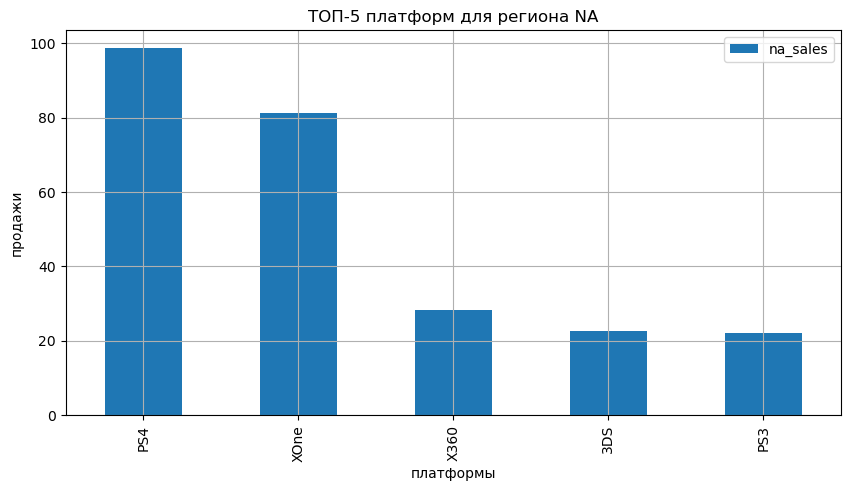

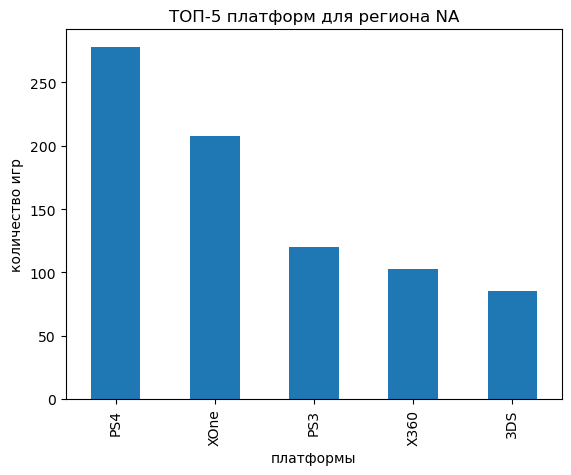

In [22]:
top5_platform_na = games_final.query('na_sales > 0')

top5_platform_na.pivot_table(index='platform', values='na_sales', aggfunc='sum').sort_values('na_sales', ascending=False).head().plot(grid=True, figsize=(10,5), kind='bar')
plt.title('ТОП-5 платформ для региона NA')
plt.xlabel('платформы')
plt.ylabel('продажи')
plt.show()

top5_platform_na_count = top5_platform_na['platform'].value_counts(ascending=False).head()

ax = top5_platform_na_count.plot.bar()

plt.title('ТОП-5 платформ для региона NA')
plt.xlabel('платформы')
plt.ylabel('количество игр')
plt.show()

Наиболее популярные платформы в Северной Америке - это PS4, XOne, PS3, X360, 3DS. Эти же 5 платформ являются и самыми прибыльными, но немного в другой последовательности - PS4, XOne, X360, 3DS, PS3.

#### Регион EU - Европа

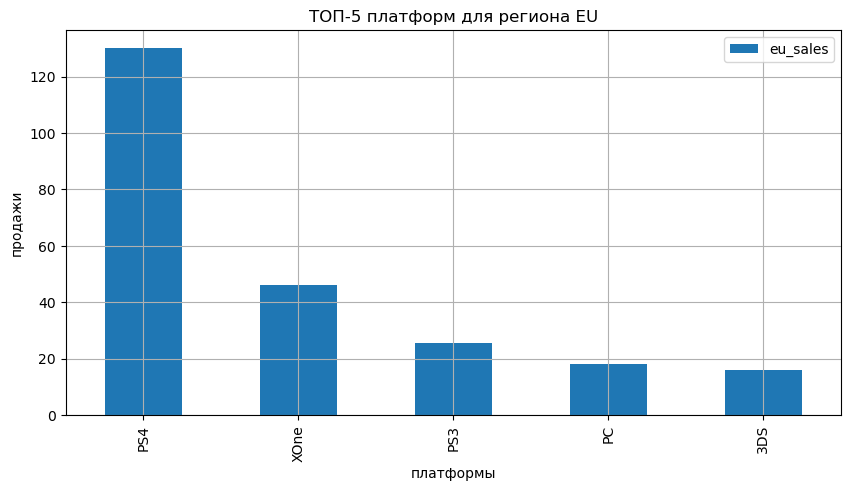

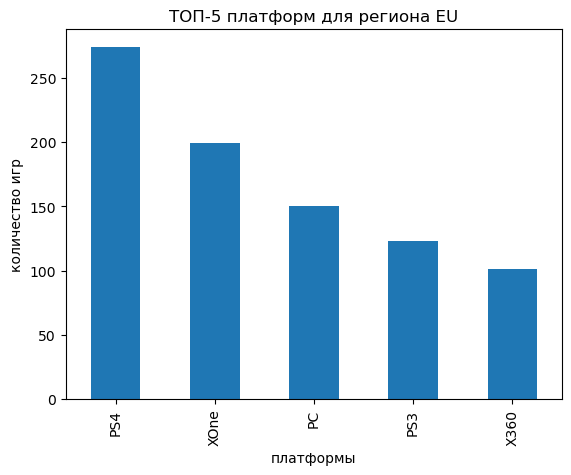

In [23]:
top5_platform_eu = games_final.query('eu_sales > 0')

top5_platform_eu.pivot_table(index='platform', values='eu_sales', aggfunc='sum').sort_values('eu_sales', ascending=False).head().plot(grid=True, figsize=(10,5), kind='bar')
plt.title('ТОП-5 платформ для региона EU')
plt.xlabel('платформы')
plt.ylabel('продажи')
plt.show()

top5_platform_eu_count = top5_platform_eu['platform'].value_counts(ascending=False).head()

ax = top5_platform_eu_count.plot.bar()

plt.title('ТОП-5 платформ для региона EU')
plt.xlabel('платформы')
plt.ylabel('количество игр')
plt.show()

В Европе в топ-5 платформ входят PS4, XOne, PC, PS3, X360. В этой пятерке есть PC вместо 3DS в Северной Америке. По прибыльности примерно тот же топ-5, но в другом порядке - PS4, XOne, PS3, PC, 3DS, где X360 сменился на 3DS.

#### Регион JP - Япония

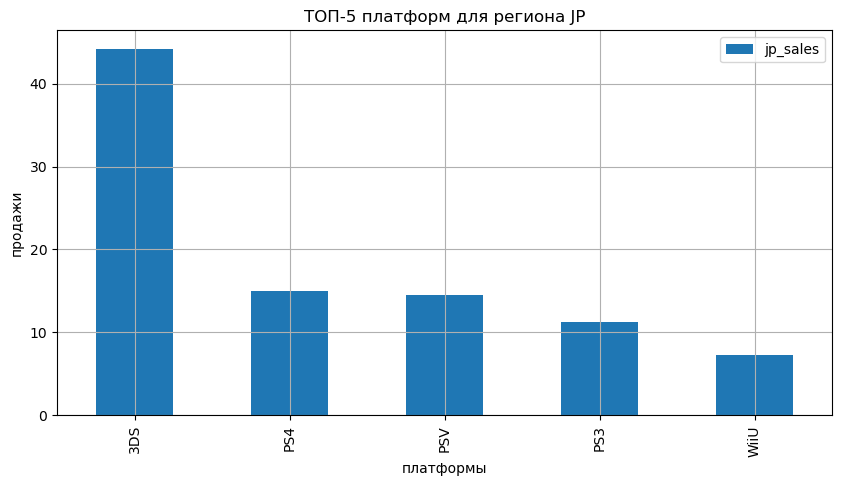

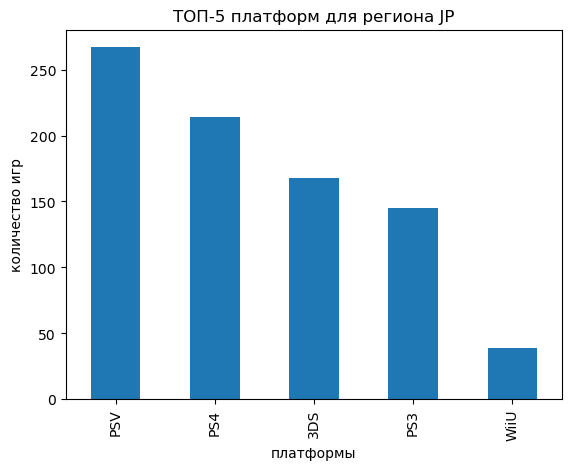

In [24]:
top5_platform_jp = games_final.query('jp_sales > 0')

top5_platform_jp.pivot_table(index='platform', values='jp_sales', aggfunc='sum').sort_values('jp_sales', ascending=False).head().plot(grid=True, figsize=(10,5), kind='bar')
plt.title('ТОП-5 платформ для региона JP')
plt.xlabel('платформы')
plt.ylabel('продажи')
plt.show()

top5_platform_jp_count = top5_platform_jp['platform'].value_counts(ascending=False).head()

ax = top5_platform_jp_count.plot.bar()

plt.title('ТОП-5 платформ для региона JP')
plt.xlabel('платформы')
plt.ylabel('количество игр')
plt.show()

В Японии в пятерку платформ входят PSV, PS4, 3DS, PS3, WiiU. В отличие от Европы и Северной Америки в этом топе есть такие платформы, как PSV, PSP и WiiU. В топ-5 по прибыльности входят те же платформы, но в другом порядке, и в особенности отрывается платформа 3DS.

### Самые популярные жанры

Взглянем теперь на ТОП-5 жанров для пользователя каждого региона (NA, EU, JP).

#### Регион NA - Северная Америка

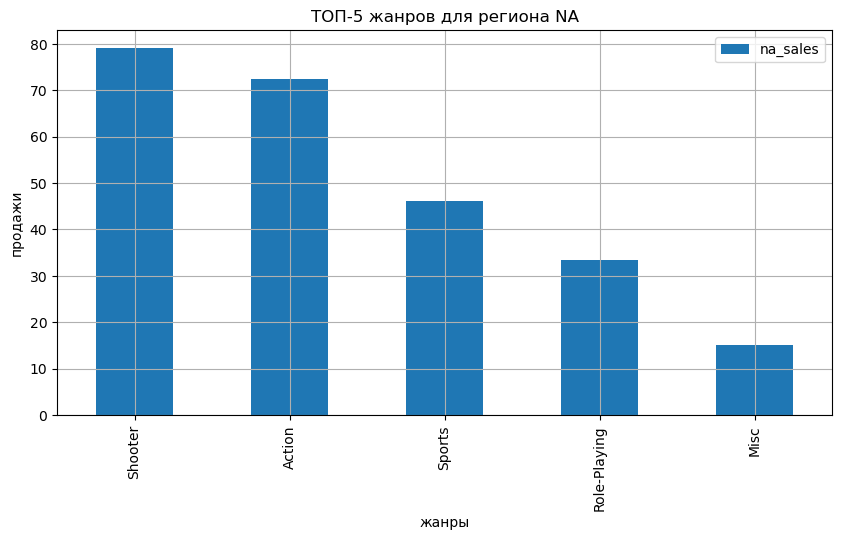

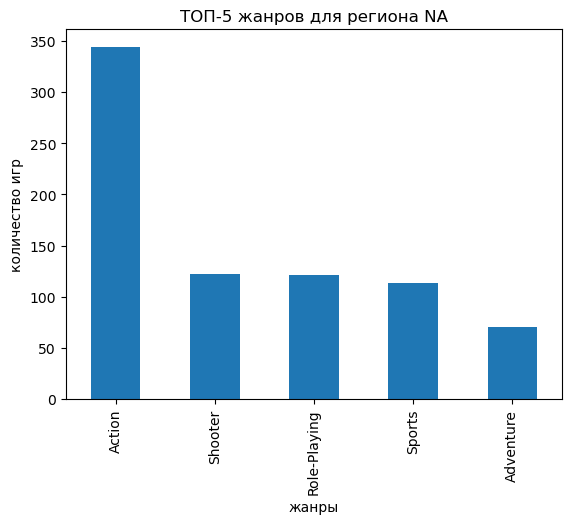

In [25]:
top5_genre_na = games_final.query('na_sales > 0')

top5_genre_na.pivot_table(index='genre', values='na_sales', aggfunc='sum').sort_values('na_sales', ascending=False).head().plot(grid=True, figsize=(10,5), kind='bar')
plt.title('ТОП-5 жанров для региона NA')
plt.xlabel('жанры')
plt.ylabel('продажи')
plt.show()

top5_genre_na_count = top5_genre_na['genre'].value_counts(ascending=False).head()

ax = top5_genre_na_count.plot.bar()

plt.title('ТОП-5 жанров для региона NA')
plt.xlabel('жанры')
plt.ylabel('количество игр')
plt.show()

В Северной Америке лидирует с сильным отрывом жанр Action, далее в пятерку входят Shooter, Role-Playing, Sports, Adventure. По прибыльности жанр Shooter обгоняет Action, на третьем месте Sports, затем Role-Playing и Misc.

#### Регион EU - Европа

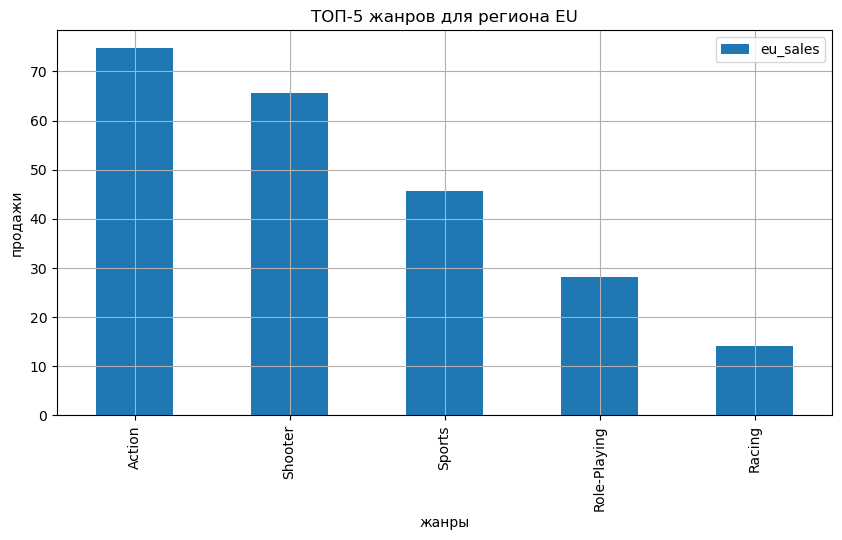

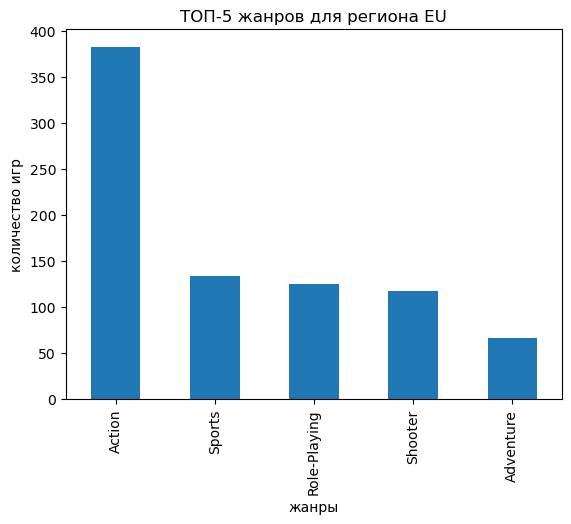

In [26]:
top5_genre_eu = games_final.query('eu_sales > 0')

top5_genre_eu.pivot_table(index='genre', values='eu_sales', aggfunc='sum').sort_values('eu_sales', ascending=False).head().plot(grid=True, figsize=(10,5), kind='bar')
plt.title('ТОП-5 жанров для региона EU')
plt.xlabel('жанры')
plt.ylabel('продажи')
plt.show()

top5_genre_eu_count = top5_genre_eu['genre'].value_counts(ascending=False).head()

ax = top5_genre_eu_count.plot.bar()

plt.title('ТОП-5 жанров для региона EU')
plt.xlabel('жанры')
plt.ylabel('количество игр')
plt.show()

В Европе также лидирует жанр Action, и в топ-5 входят те же жанры, но в другом порядке - Sports, Role-Playing, Shooter, Adventure. По прибыльности на первом месте тоже Action, за ним сразу Shooter, Sports, Role-Playing и Racing, которого не было в топе по количеству игр.

#### Регион JP - Япония

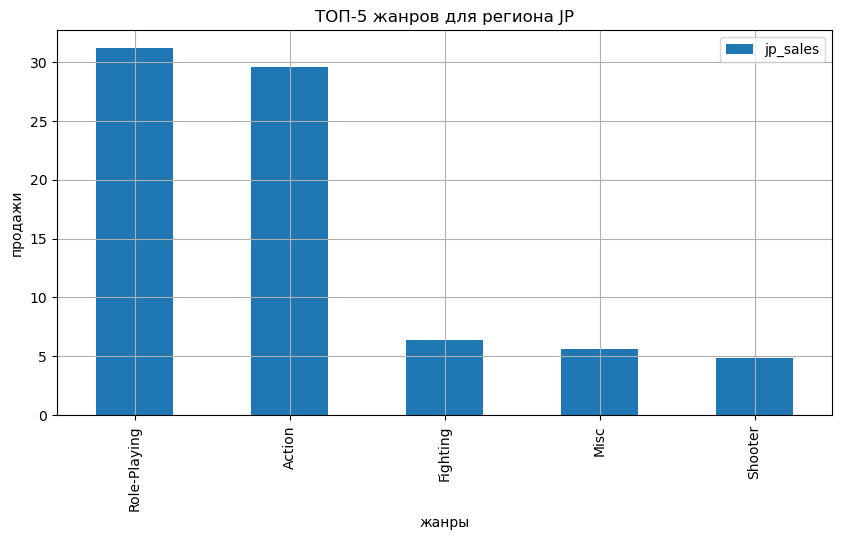

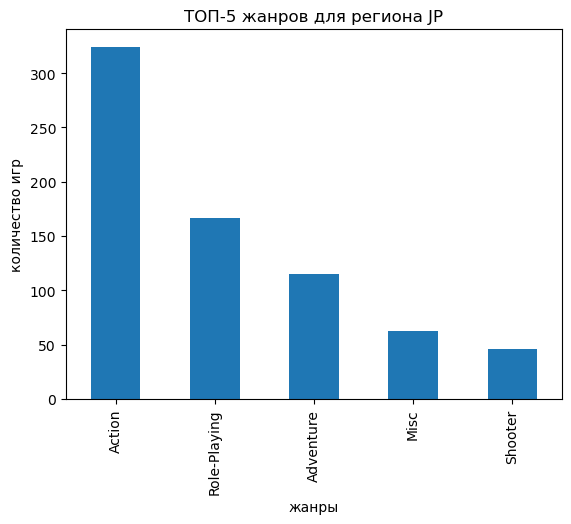

In [27]:
top5_genre_jp = games_final.query('jp_sales > 0')

top5_genre_jp.pivot_table(index='genre', values='jp_sales', aggfunc='sum').sort_values('jp_sales', ascending=False).head().plot(grid=True, figsize=(10,5), kind='bar')
plt.title('ТОП-5 жанров для региона JP')
plt.xlabel('жанры')
plt.ylabel('продажи')
plt.show()

top5_genre_jp_count = top5_genre_jp['genre'].value_counts(ascending=False).head()

ax = top5_genre_jp_count.plot.bar()

plt.title('ТОП-5 жанров для региона JP')
plt.xlabel('жанры')
plt.ylabel('количество игр')
plt.show()

В Японии топ-5 по количеству игр отличается, на первом месте всё так же жанр Action, но дальше картина меняется. На втором месте Role-Playing, затем Adventure, Misc и Shooter. Любопытно, что по прибыльности жанр Role-Playing обошел Action. На третьем месте Fighting, затем Misc и Shooter. 

### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

Посмотрим, как идут продажи в каждом регионе в зависимости от рейтинга ESRB.

Но сначала расшифруем значения:
- M («Mature») — «Для взрослых»;
- E («Everyone») — «Для всех»;
- E10+ («Everyone 10 and older») — «Для всех от 10 лет и старше»;
- T («Teen») — «Подросткам»;
- EC («Early childhood») — «Для детей младшего возраста»;
- RP - шаблон без параметра-

#### Регион NA - Северная Америка

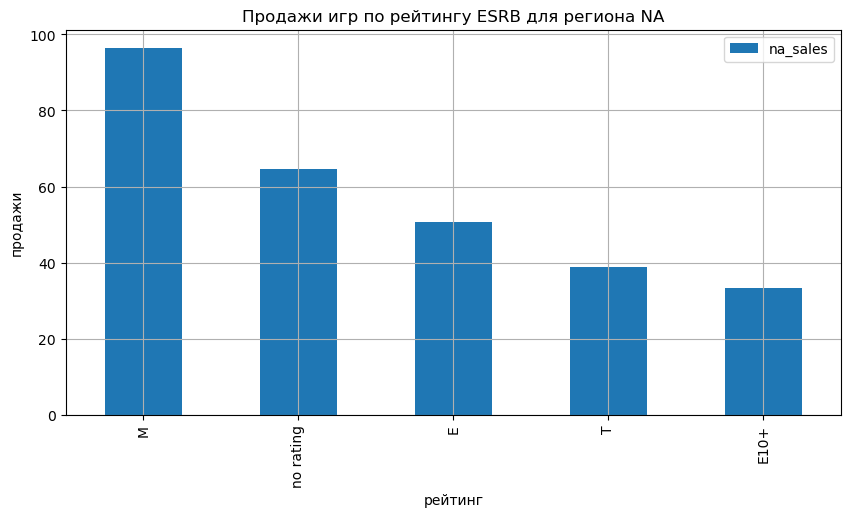

In [28]:
top5_genre_na.pivot_table(index='rating', values='na_sales', aggfunc='sum').sort_values('na_sales', ascending=False).plot(grid=True, figsize=(10,5), kind='bar')
plt.title('Продажи игр по рейтингу ESRB для региона NA')
plt.xlabel('рейтинг')
plt.ylabel('продажи')
plt.show()

В Северной Америке больше всего продаж игр с рейтингом «Для взрослых», далее идет значительная доля игр без рейтинга, и уже после - рейтинги «Для всех», «Подросткам» и «Для всех от 10 лет и старше». 

#### Регион EU - Европа

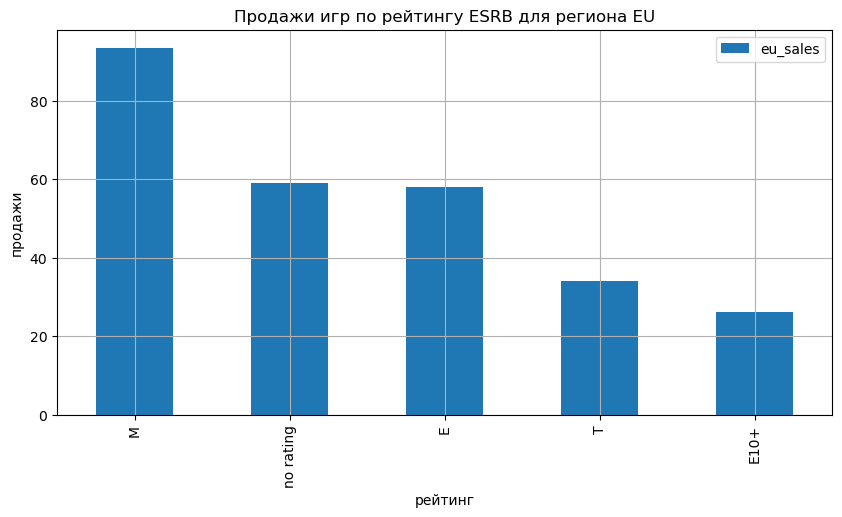

In [29]:
top5_genre_eu.pivot_table(index='rating', values='eu_sales', aggfunc='sum').sort_values('eu_sales', ascending=False).plot(grid=True, figsize=(10,5), kind='bar')
plt.title('Продажи игр по рейтингу ESRB для региона EU')
plt.xlabel('рейтинг')
plt.ylabel('продажи')
plt.show()

В Европе также лидируют игры с рейтингом «Для взрослых», на втором месте тоже игры без рейтинга, затем «Для всех», «Подросткам», «Для всех от 10 лет и старше». Примерно такая же картина, как в Северной Америке.

#### Регион JP - Япония

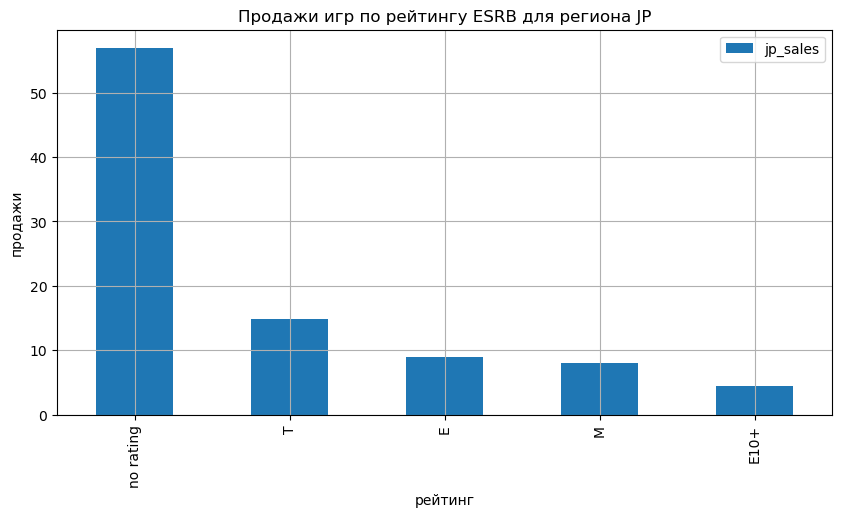

In [30]:
top5_genre_jp.pivot_table(index='rating', values='jp_sales', aggfunc='sum').sort_values('jp_sales', ascending=False).plot(grid=True, figsize=(10,5), kind='bar')
plt.title('Продажи игр по рейтингу ESRB для региона JP')
plt.xlabel('рейтинг')
plt.ylabel('продажи')
plt.show()

В Японии картина отличается, на первом месте огромная доля игр без рейтинга, затем «Подросткам», «Для всех», и только потом игры с рейтингом «Для взрослых» и «Для всех от 10 лет и старше».

### Промежуточный вывод
- **ТОП-5 платформ**:
 - в Северной Америке - PS4, XOne, PS3, X360, 3DS, самая прибыльная - PS4;
 - в Европе - PS4, XOne, PC, PS3, X360, самая прибыльная - PS4;
 - в Японии - PSV, PS4, 3DS, PS3, WiiU, самая прибыльная - 3DS.
- **ТОП-5 жанров**:
 - в Северной Америке - Action, Shooter, Role-Playing, Sports, Adventure, самый прибыльный - Shooter;
 - в Европе - Action, Sports, Role-Playing, Shooter, Adventure, самый прибыльный - Action;
 - в Японии - Action, Role-Playing, Adventure, Misc и Shooter, самый прибыльный - Role-Playing.
- **Влияние рейтинга ESRB на продажи**:
 - в Северной Америке лидирует рейтинг «Для взрослых», далее идет значительная доля игр без рейтинга, и уже после - рейтинги «Для всех», «Подросткам» и «Для всех от 10 лет и старше»;
 - в Европе тоже «Для взрослых», на втором месте также игры без рейтинга, затем «Для всех», «Подросткам», «Для всех от 10 лет и старше»;
 - в Японии лидирует огромная доля игр без рейтинга, затем «Подросткам», «Для всех», и только потом игры с рейтингом «Для взрослых» и «Для всех от 10 лет и старше».

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

**Нулевая гипотеза**: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

**Альтернативная гипотеза**: Средние пользовательские рейтинги платформ Xbox One и PC разные.

In [31]:
sample_1 = games_final.query('(platform == "XOne") and (user_score > 0)')['user_score']
sample_2 = games_final.query('(platform == "PC") and (user_score > 0)')['user_score']
alpha = 0.01
results_platform = st.ttest_ind(sample_1, sample_2, alternative='two-sided')

print('среднее значение для платформы XOne:', sample_1.mean())
print('среднее значение для платформы PC:', sample_2.mean())

print('p-значение:', results_platform.pvalue)

if results_platform.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

среднее значение для платформы XOne: 6.594545454545456
среднее значение для платформы PC: 6.298360655737705
p-значение: 0.10450507919348415
Не получилось отвергнуть нулевую гипотезу


Мы взяли в качестве нулевой гипотезы утверждение о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Рассчитав p-value, мы не отвергаем эту гипотезу. По средним значением мы видим, что рейтинги действительно близки.

### Средние пользовательские рейтинги жанров Action и Sports одинаковые

**Нулевая гипотеза**: Средние пользовательские рейтинги жанров Action и Sports одинаковые.

**Альтернативная гипотеза**: Средние пользовательские рейтинги жанров Action и Sports разные.

In [32]:
sample_3 = games_final.query('(genre == "Action") and (user_score > 0)')['user_score']
sample_4 = games_final.query('(genre == "Sports") and (user_score > 0)')['user_score']

results_genre = st.ttest_ind(sample_3, sample_4, alternative='two-sided')

print('среднее значение для жанра Action:', sample_3.mean())
print('среднее значение для жанра Sports:', sample_4.mean())

print('p-значение:', results_genre.pvalue)

if results_genre.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

среднее значение для жанра Action: 6.760606060606061
среднее значение для жанра Sports: 5.2251968503937
p-значение: 2.8711147985105864e-19
Отвергаем нулевую гипотезу


Здесь мы также предполагали, что средние пользовательские рейтинги жанров Action и Sports одинаковы. Однако рассчитав p-value, мы отвергаем нулевую гипотезу в пользу альтернативной о том, что рейтинги разные.

### Промежуточный вывод
Мы проверили две гипотезы и остановились на следующем:
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action и Sports разные.

Таким образом, популярность платформ Xbox One и PC среди пользователей примерно на одном уровне, а вот жанры Action и Sports сильно различаются, мы наблюдали эту тенденцию на протяжении всего исследования.

## Общий вывод

В ходе исследования мы проделали несколько этапов.

**Мы познакомились с данными**:
В датафрейме 16 715 строк, у нас есть информация по названиям игр, их жанрам, году выпуска, платформам, где можно в них играть, а также данные о продажам в разных регионах, оценки критиков и пользователей и возрастной рейтинг.

**Обработали данные**:
- переименовали столбцы в "змеином" регистре;
- изменили типы данных в столбцах "user_score" и "year_of_release" на float64 и int64 соответственно;
- удалили пропуски в столбцах "year_of_release", "name" и "genre", а в столбцах "critic_score" и "user_score" оставили, поскольку пропусков слишком много, и замена медианой может сильно исказить данные, в столбце "rating" заменили все пропуски на категорию 'no rating' для дальнейшего анализа;
- проверили данные на наличие дубликатов, нашли один по комбинации - название игры, платформа, год выпуска - и удалили;
- добавили столбец с расчетом суммарных продаж во всех регионах.

**Провели исследовательский анализ**:
- **Распределение по годам**. На период с 1985 до 2000 год приходится небольшой процент игр, а основная масса выходила с 2000 по 2016;
- **Продажи по платформам**. Наибольшие суммарные продажи за весь перид с 1985 по 2016 гг. приходятся на следующие платформы - PS2, X360, PS3, Wii, DS и PS;
- **Срок жизни платформ**. Характерный срок для платформ длится от 6 до 10 лет, поэтому далее мы рассматриваем данные за последние 3 года, то есть с 2014 по 2016;
- **Наиболее прибыльные платформы за последние 3 года** - это PS4, XOne и X360, но у последней количество игр идёт с каждым годом на спад, а PS4 и XOne только набирают обороты, так что на них стоит обратить внимание как на потенциально прибыльные;
- **Зависимость продаж от оценок**. Строгой зависимости продаж от оценок пользователей не наблюдается, но по оценке критиков мы видим общую тенденцию - с увеличением продаж выше оценки критиков;
- **Продажи по жанрам**: 
 - подавляющее большинство игр за последние 3 года относятся к жанру Action, следующими по популярности идут жанры Role-Playing, Adventure, Sports, Shooter и Misc;
 - несмотря на то, что в жанре Action вышло больше всего игр, стабильно приносит высокий доход жанр Shooter, а Action оказывается на 7 месте. Далее по продажам после Shooter идут Sports, Platform, Fighting и Role-Playing;
 - наименее популярными являются жанры Strategy и Puzzle, по прибыльности они также на последнем месте, при этом жанр Adventure, который был на третьем месте по количеству игр, оказался на последнем месте по прибыльности.
 
**Составили портрет пользователя каждого региона**:
- **ТОП-5 платформ**:
 - в Северной Америке - PS4, XOne, PS3, X360, 3DS, самая прибыльная - PS4;
 - в Европе - PS4, XOne, PC, PS3, X360, самая прибыльная - PS4;
 - в Японии - PSV, PS4, 3DS, PS3, WiiU, самая прибыльная - 3DS.
- **ТОП-5 жанров**:
 - в Северной Америке - Action, Shooter, Role-Playing, Sports, Adventure, самый прибыльный - Shooter;
 - в Европе - Action, Sports, Role-Playing, Shooter, Adventure, самый прибыльный - Action;
 - в Японии - Action, Role-Playing, Adventure, Misc и Shooter, самый прибыльный - Role-Playing.
- **Влияние рейтинга ESRB на продажи**:
 - в Северной Америке лидирует рейтинг «Для взрослых», далее идет значительная доля игр без рейтинга, и уже после - рейтинги «Для всех», «Подросткам» и «Для всех от 10 лет и старше»;
 - в Европе тоже «Для взрослых», на втором месте также игры без рейтинга, затем «Для всех», «Подросткам», «Для всех от 10 лет и старше»;
 - в Японии лидирует огромная доля игр без рейтинга, затем «Подросткам», «Для всех», и только потом игры с рейтингом «Для взрослых» и «Для всех от 10 лет и старше».
 
**Проверили две гипотезы и остановились на следующих**:
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action и Sports разные.
 - Популярность платформ Xbox One и PC среди пользователей примерно на одном уровне, а вот жанры Action и Sports сильно различаются, мы наблюдали эту тенденцию на протяжении всего исследования.
 
**Общие рекомендации**:

Учитывая вышеперечисленные выводы, мы рекомендуем ориентироваться на следующие параметры:
- ***Предпочитаемые платформы*** - PS4 и XOne;
- ***Предпочитаемые жанры*** - Action, Shooter и Role-Playing;
- ***Предпочитаемый возрастной рейтинг*** - «Для взрослых» и «Для всех».
- ***Предпочитаемые регионы*** - Северная Америка и Европа.